In [1]:
import os

# Change working directory
os.chdir(r'd:\Programing\Youtube_Comment_Sentiments_&_Type_Analysis')

print("Current working directory:", os.getcwd())

Current working directory: d:\Programing\Youtube_Comment_Sentiments_&_Type_Analysis


*****
## Necessary Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import banglanltk
import re
import random
import string
import joblib

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bnltk.stemmer import BanglaStemmer
from wordcloud import WordCloud
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# set working directory
import os
os.chdir(r'd:\Programing\Youtube_Comment_Sentiments_&_Type_Analysis')

import warnings
warnings.filterwarnings("ignore")

# custom module
from scripts.utils import *
# from modules.bangla_stopwords import bangla_stopwords
# from modules.slang_text import slang_text_dict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sajan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*****
## Dataset Loading and Basic Statistics

In [3]:
df = pd.read_csv("./data/youtube_comment_dataset.csv")
df.head()

,Unnamed: 0,comment,type,sentiment
0,0,"গানটা যখন শুনছি, তখনই এই শহরটা ছাড়ার ঘন্টা বেঁ...",emotional,negative
1,1,tnx gan ta onak sundor.we hope that amon sundo...,emotional,positive
2,2,ei shohor amar are or our noy,emotional,negative
3,3,"যারা নিজের এলাকা ছেড়ে দূরে চলে গেছে, তাদের জন্...",emotional,positive
4,4,"আজ ২২-১০-২৫ স্মীতি রেখে গেলাম আপনাদের মাঝে,,,য...",informative,positive


In [4]:
df.shape

(21398, 4)

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    21398 non-null  object
 1   type       21277 non-null  object
 2   sentiment  21277 non-null  object
dtypes: object(3)
memory usage: 501.6+ KB


In [7]:
df.describe()

,comment,type,sentiment
count,21398,21277,21277
unique,20092,11,7
top,2025,emotional,neutral
freq,38,10602,8670


In [8]:
df.isnull().sum()

comment        0
type         121
sentiment    121
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.duplicated('comment').sum()

np.int64(1296)

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20031 entries, 0 to 21397
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    20031 non-null  object
 1   type       20031 non-null  object
 2   sentiment  20031 non-null  object
dtypes: object(3)
memory usage: 626.0+ KB


In [13]:
print("Sentiment Counts:", df['sentiment'].value_counts())
print("\nType Counts:", df['type'].value_counts())

Sentiment Counts: sentiment
neutral     7986
positive    6854
negative    5029
Neutral      112
Negative      34
Positive      12
mixed          4
Name: count, dtype: int64

Type Counts: type
emotional      10206
informative     4115
opinion         3977
question        1378
promotional      177
Question          92
Opinion           38
Emotional         27
request           11
neutral            9
Informative        1
Name: count, dtype: int64


In [14]:
for index, row in df.iterrows():
    row['type'] = row['type'].lower()
    row['sentiment'] = row['sentiment'].lower()

In [15]:
print("Sentiment Counts:", df['sentiment'].value_counts())
print("\nType Counts:", df['type'].value_counts())

Sentiment Counts: sentiment
neutral     8098
positive    6866
negative    5063
mixed          4
Name: count, dtype: int64

Type Counts: type
emotional      10233
informative     4116
opinion         4015
question        1470
promotional      177
request           11
neutral            9
Name: count, dtype: int64


In [16]:
df = df[df['sentiment'] != 'mixed']
df = df[~df['type'].isin(['neutral', 'request'])]

df.reset_index(drop=True, inplace=True)

df.shape

(20007, 3)

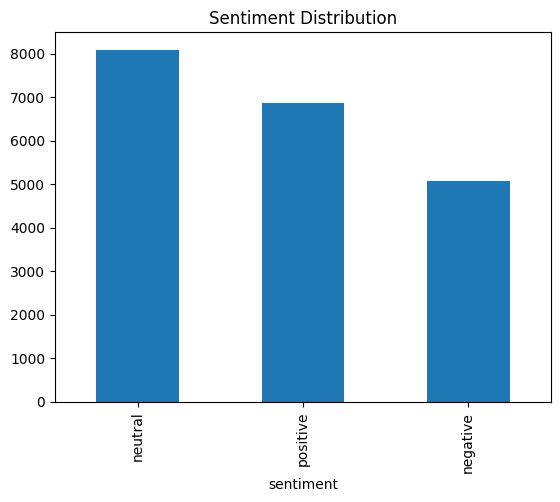

In [17]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

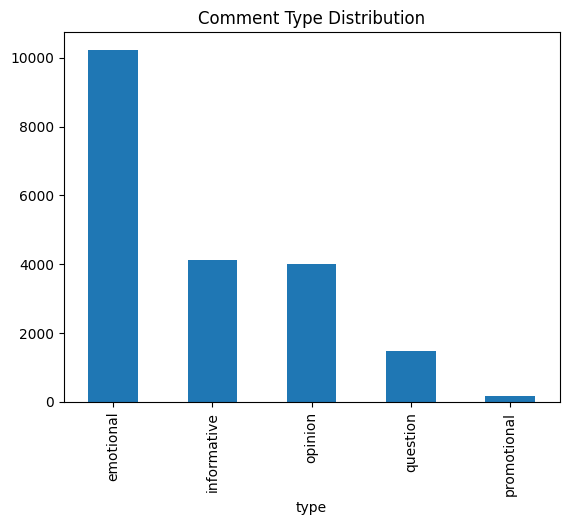

In [18]:
df['type'].value_counts().plot(kind='bar')
plt.title("Comment Type Distribution")
plt.show()

*****
## Preprocessing

In [19]:
df.head()

,comment,type,sentiment
0,"গানটা যখন শুনছি, তখনই এই শহরটা ছাড়ার ঘন্টা বেঁ...",emotional,negative
1,tnx gan ta onak sundor.we hope that amon sundo...,emotional,positive
2,ei shohor amar are or our noy,emotional,negative
3,"যারা নিজের এলাকা ছেড়ে দূরে চলে গেছে, তাদের জন্...",emotional,positive
4,"আজ ২২-১০-২৫ স্মীতি রেখে গেলাম আপনাদের মাঝে,,,য...",informative,positive


In [50]:
# Test the remove_bangla_numbers function
sample = random.choice(df['comment'].values)
sample
print("Original Comment:\n", sample)
print("\nAfter Removing bangla numbers:\n", remove_bangla_numbers(sample))

Original Comment:
 শৈশবে বন্ধুদেরর সাথে খেলাধুলা নদিতে গোসল করা, এক পাড়া থেকে অন্য পাড়ায় দৌড়ে দৌড়ে যাওয়া আসা ,সকালে ঘুম থেকে উঠে যাদের মুখ সবার আগে দেখতাম আজ সেই শৈশব সেই বন্ধুরা যেন সবাই হারিয়ে গিয়েছে । যেই বন্ধু, যেই গ্রাম ছেড়ে একটি রাতও পার করে পারতাম না আজ সেই বন্ধুদের সাথে বছরে এক বারও দেখা হয়না! সেই গ্রাম যেন আজ অপরিচিত হয়ে গেছে ! জীবিকার তাগিদে আজ সবাই ভিন্ন ভিন্ন পথে! শৈশবের কথা মনে পড়লে অনেক কষ্ট হয়(২৬-০৯-২০২৫)লাইক দিলে শৈশবের টানে আবার শুনে যাবো

After Removing bangla numbers:
 শৈশবে বন্ধুদেরর সাথে খেলাধুলা নদিতে গোসল করা, এক পাড়া থেকে অন্য পাড়ায় দৌড়ে দৌড়ে যাওয়া আসা ,সকালে ঘুম থেকে উঠে যাদের মুখ সবার আগে দেখতাম আজ সেই শৈশব সেই বন্ধুরা যেন সবাই হারিয়ে গিয়েছে । যেই বন্ধু, যেই গ্রাম ছেড়ে একটি রাতও পার করে পারতাম না আজ সেই বন্ধুদের সাথে বছরে এক বারও দেখা হয়না! সেই গ্রাম যেন আজ অপরিচিত হয়ে গেছে ! জীবিকার তাগিদে আজ সবাই ভিন্ন ভিন্ন পথে! শৈশবের কথা মনে পড়লে অনেক কষ্ট হয়(--)লাইক দিলে শৈশবের টানে আবার শুনে যাবো


In [51]:
# creating 2 versions of cleaned comments
# Version 1: remove punctuation, special characters, and replace the slang text to train the BERT model
# Version 2: remove punctuation, special characters, stopwords, numbers, bangla numbers to train traditional ML and DL models

df['clean_comment_v1'] = df['comment'].apply(remove_punctuation)
df['clean_comment_v1'] = df['clean_comment_v1'].apply(remove_special_characters)
df['clean_comment_v1'] = df['clean_comment_v1'].apply(replace_slang)
df['clean_comment_v2'] = df['clean_comment_v1'].apply(remove_stopwords)
df['clean_comment_v2'] = df['clean_comment_v2'].apply(remove_numbers)
df['clean_comment_v2'] = df['clean_comment_v2'].apply(remove_bangla_numbers)

In [52]:
df.sample(10)

,comment,type,sentiment,clean_comment_v1,clean_comment_v2
14886,tomar motoi bokachoda,emotional,negative,tomar motoi bokachoda,tomar motoi bokachoda
18597,md sujon khan,informative,neutral,md sujon khan,md sujon khan
15068,all,informative,neutral,all,
16472,hatir matha..kukurer matha... khub valo laglo..,opinion,positive,hatir mathakukurer matha khub valo laglo,hatir mathakukurer matha khub valo laglo
5647,হাই স্কুল লাইফ,informative,neutral,হাই স্কুল লাইফ,হাই স্কুল লাইফ
1253,কতবার গানটা শুনছি নিজে যানি না আমার সাথে পুরা ...,emotional,positive,কতবার গানটা শুনছি নিজে যানি না আমার সাথে পুরা ...,কতবার গানটা শুনছি যানি না সাথে পুরা মিলে
9500,who &#39;s watching this in 2025,question,neutral,who 39s watching this in 2025,s watching
14779,amar shob kotai relatable but ganna. com beshi...,opinion,positive,amar shob kotai relatable but ganna com beshi ...,amar shob kotai relatable ganna com beshi rela...
7635,love from nepal,emotional,positive,love from nepal,love nepal
6036,পৃথিবীতে সবচেয়ে বড় মিথ্যা কথা..!! আমি ভালো আছি...,emotional,negative,পৃথিবীতে সবচেয়ে বড় মিথ্যা কথা আমি ভালো আছি,পৃথিবীতে সবচেয়ে বড় মিথ্যা কথা ভালো আছি


In [53]:
# helper function to recognizee language
def is_bangla(text):
    for ch in text:
        if '\u0980' <= ch <= '\u09FF':
            return True
    return False

def is_english(text):
    for ch in text:
        if 'a' <= ch <= 'z' or 'A' <= ch <= 'Z':
            if not is_bangla(text):
                return True
    return False

In [55]:
# test the functions
sample = df['clean_comment_v1'][random.randint(0, len(df)-1)]
print("Sample Text:",sample)
print("Is Bangla?:", is_bangla(sample))
print("Is English?:", is_english(sample))

Sample Text: দাদা ভইডইয় টা কিন্তু দারুন
Is Bangla?: True
Is English?: False


In [56]:
df['clean_comment_v2'] = df['clean_comment_v2'].apply(lambda x: stem_text(x, verbose=False))

df.sample(10)

applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied third rules..
applied fourth rules..
applied fourth rules..
app

,comment,type,sentiment,clean_comment_v1,clean_comment_v2
2413,১৭ bochor boyoshei nijer mrittu holeo ২৫ e jon...,opinion,positive,১৭ bochor boyoshei nijer mrittu holeo ২৫ e jon...,bochor boyoshei nijer mrittu holeo e jontrona ...
1780,আয়নায় তাকিয়ে ভাবি অপরাধ কি আমার আমার কি দোষ? আ...,emotional,negative,আয়নায় তাকিয়ে ভাবি অপরাধ কি আমার আমার কি দোষ আহ...,আয়নায় তাকা ভাবি অপরাধ দোষ আহ চমৎক কখনো পারবে না
8502,who is in september 2025?,question,neutral,who is in september 2025,septemb
10694,haste haste ami pagolo hoye jete pari....dukkh...,emotional,negative,haste haste ami pagolo hoye jete paridukkher b...,hast hast ami pagolo hoy jete paridukkh bishoy...
19293,you are the best guys,opinion,positive,you are the best guys,best guy
18559,uncel oi uju koi kormu,emotional,neutral,uncel oi uju koi kormu,uncel oi uju koi kormu
10495,sera legeche kiran da,informative,neutral,sera legeche kiran da,sera legech kiran da
18694,jawani,informative,neutral,jawani,jawani
989,notun kore bachte sikhchi 25 a,opinion,neutral,notun kore bachte sikhchi 25 a,notun kore bacht sikhchi
12462,are or our ami akhon mrito,question,neutral,are or our ami akhon mrito,ami akhon mrito


In [57]:
for index, row in df.iterrows():
    if str(row['clean_comment_v2']).strip() == "":
        df.at[index, 'clean_comment_v2'] = np.nan

df.isnull().sum()

comment               0
type                  0
sentiment             0
clean_comment_v1      0
clean_comment_v2    519
dtype: int64

In [59]:
df.dropna(inplace=True)

In [60]:
df.isnull().sum()

comment             0
type                0
sentiment           0
clean_comment_v1    0
clean_comment_v2    0
dtype: int64

In [61]:
df.drop(columns=['comment'], inplace=True)

In [113]:
# final dataset info before encoding
print(f"Shape of the dataset: {df.shape}\n")
df.info()

Shape of the dataset: (19488, 4)

<class 'pandas.core.frame.DataFrame'>
Index: 19488 entries, 0 to 20006
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   type              19488 non-null  object
 1   sentiment         19488 non-null  object
 2   clean_comment_v1  19488 non-null  object
 3   clean_comment_v2  19488 non-null  object
dtypes: object(4)
memory usage: 761.2+ KB


In [114]:
df.head()

,type,sentiment,clean_comment_v1,clean_comment_v2
0,emotional,negative,গানটা যখন শুনছি তখনই এই শহরটা ছাড়ার ঘন্টা বেঁজ...,গান শুন তখন শহর ছাড়া ঘন্ বেঁজে মাসে বাসা ছেড়েছ...
1,emotional,positive,tnx gan ta onak sundorwe hope that amon sundor...,tnx gan ta onak sundorw hope amon sundor gan a...
2,emotional,negative,ei shohor amar are or our noy,ei shohor amar noy
3,emotional,positive,যারা নিজের এলাকা ছেড়ে দূরে চলে গেছে তাদের জন্য...,এলাকা ছাড় গান সুর নয়প্রতি লাইনই একেক স্মৃতির আকাশ
4,informative,positive,আজ ২২১০২৫ স্মীতি রেখে গেলাম আপনাদের মাঝেযখনই ল...,স্মীতি গেল আপনা মাঝেযখন লাইক দিব নোটিফিকেশন আস...


In [115]:
# analyzing comment lengths
df['seq_len_v1'] = df['clean_comment_v1'].apply(lambda x: len(x.split()))
df['seq_len_v2'] = df['clean_comment_v2'].apply(lambda x: len(x.split()))

# version 1 analysis
print("Version 1 Analysis:")
print(f"Maximum Sequence Length: {df['seq_len_v1'].max()}")
print(f"Minimum Sequence Length: {df['seq_len_v1'].min()}")
print(f"Average Sequence Length: {df['seq_len_v1'].mean()}")

# version 2 analysis
print("\nVersion 2 Analysis:")
print(f"Maximum Sequence Length: {df['seq_len_v2'].max()}")
print(f"Minimum Sequence Length: {df['seq_len_v2'].min()}")
print(f"Average Sequence Length: {df['seq_len_v2'].mean()}")

Version 1 Analysis:
Maximum Sequence Length: 479
Minimum Sequence Length: 1
Average Sequence Length: 9.70017446633826

Version 2 Analysis:
Maximum Sequence Length: 476
Minimum Sequence Length: 1
Average Sequence Length: 6.719571018062397


In [122]:
def plot_length_distribution(df):
    fig, axis = plt.subplots(1, 2, figsize=(16, 6))

    # Version 1
    axis[0].hist(df['seq_len_v1'], bins=50, color='skyblue', edgecolor='black')
    axis[0].set_title("Comment Length Distribution (Version 1)")
    axis[0].set_xlabel("Length of Comment") 
    axis[0].set_ylabel("Frequency")

    # Version 2
    axis[1].hist(df['seq_len_v2'], bins=50, color='salmon', edgecolor='black')
    axis[1].set_title("Comment Length Distribution (Version 2)")
    axis[1].set_xlabel("Length of Comment")
    axis[1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

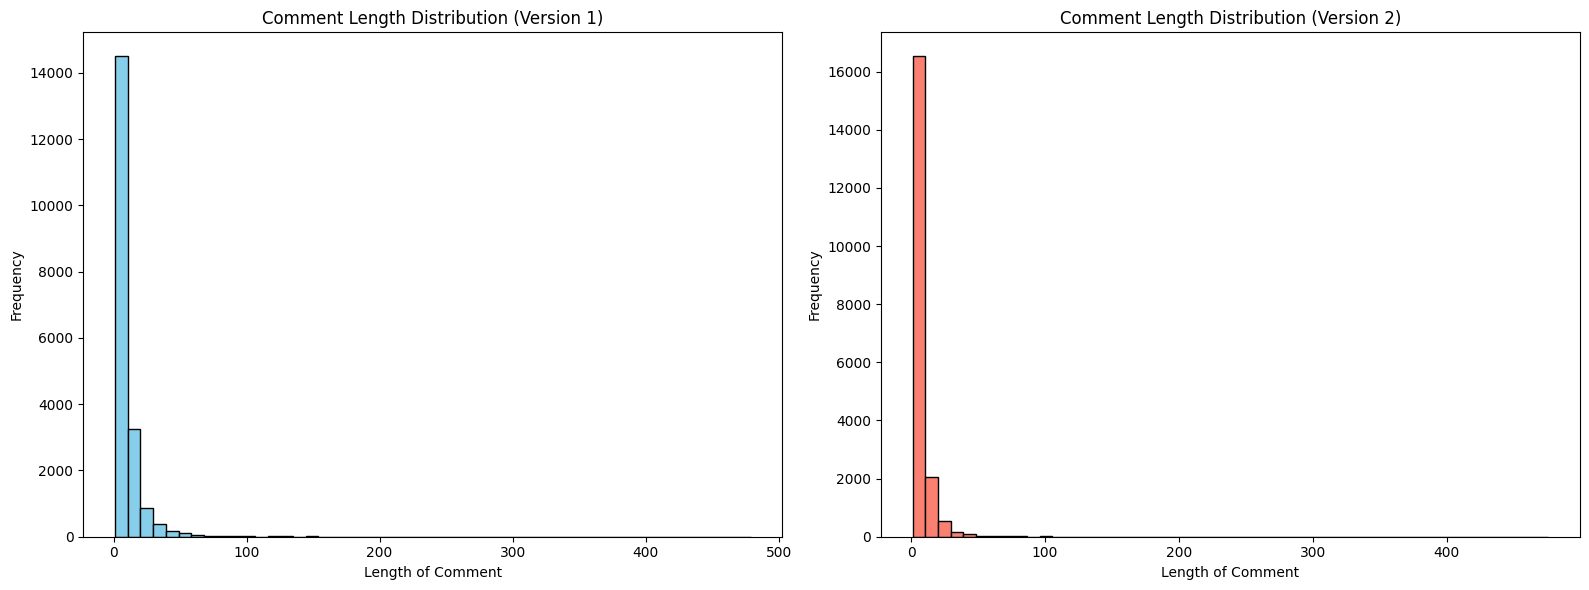

In [123]:
plot_length_distribution(df)

In [130]:
print(f"Number of comments with length <= 200 in Version 1: {(df['clean_comment_v1'].str.len() <= 200).sum()}")
print(f"Number of comments with length  > 200 in Version 1: {(df['clean_comment_v1'].str.len() > 200).sum()}")

print(f"Number of comments with length <= 200 in Version 2: {(df['clean_comment_v2'].str.len() <= 200).sum()}")
print(f"Number of comments with length  > 200 in Version 2: {(df['clean_comment_v2'].str.len() > 200).sum()}")

Number of comments with length <= 200 in Version 1: 18924
Number of comments with length  > 200 in Version 1: 564
Number of comments with length <= 200 in Version 2: 19242
Number of comments with length  > 200 in Version 2: 246


### Since BERT can handle variable-length sequences, we don't need to limit the comment length for it. However, traditional ML/DL models (like LSTMs) require fixed-length input sequences. Most of our comments are under 200 characters, so we decided to remove comments longer than 200 in Version 2. This helps keep the sequence length manageable for training models like LSTM.

In [135]:
# removing comments with length greater than 200 
df = df[df['clean_comment_v2'].str.len() <= 200].reset_index(drop=True)

In [139]:
# analyzing comment lengths after removing long comments
df['seq_len_v1'] = df['clean_comment_v1'].apply(lambda x: len(x.split()))
df['seq_len_v2'] = df['clean_comment_v2'].apply(lambda x: len(x.split()))

# version 1 analysis
print("Version 1 Analysis:")
print(f"Maximum Sequence Length: {df['seq_len_v1'].max()}")
print(f"Minimum Sequence Length: {df['seq_len_v1'].min()}")
print(f"Average Sequence Length: {df['seq_len_v1'].mean()}")

# version 2 analysis
print("\nVersion 2 Analysis:")
print(f"Maximum Sequence Length: {df['seq_len_v2'].max()}")
print(f"Minimum Sequence Length: {df['seq_len_v2'].min()}")
print(f"Average Sequence Length: {df['seq_len_v2'].mean()}")

Version 1 Analysis:
Maximum Sequence Length: 221
Minimum Sequence Length: 1
Average Sequence Length: 8.56563766760212

Version 2 Analysis:
Maximum Sequence Length: 42
Minimum Sequence Length: 1
Average Sequence Length: 5.921785677164536


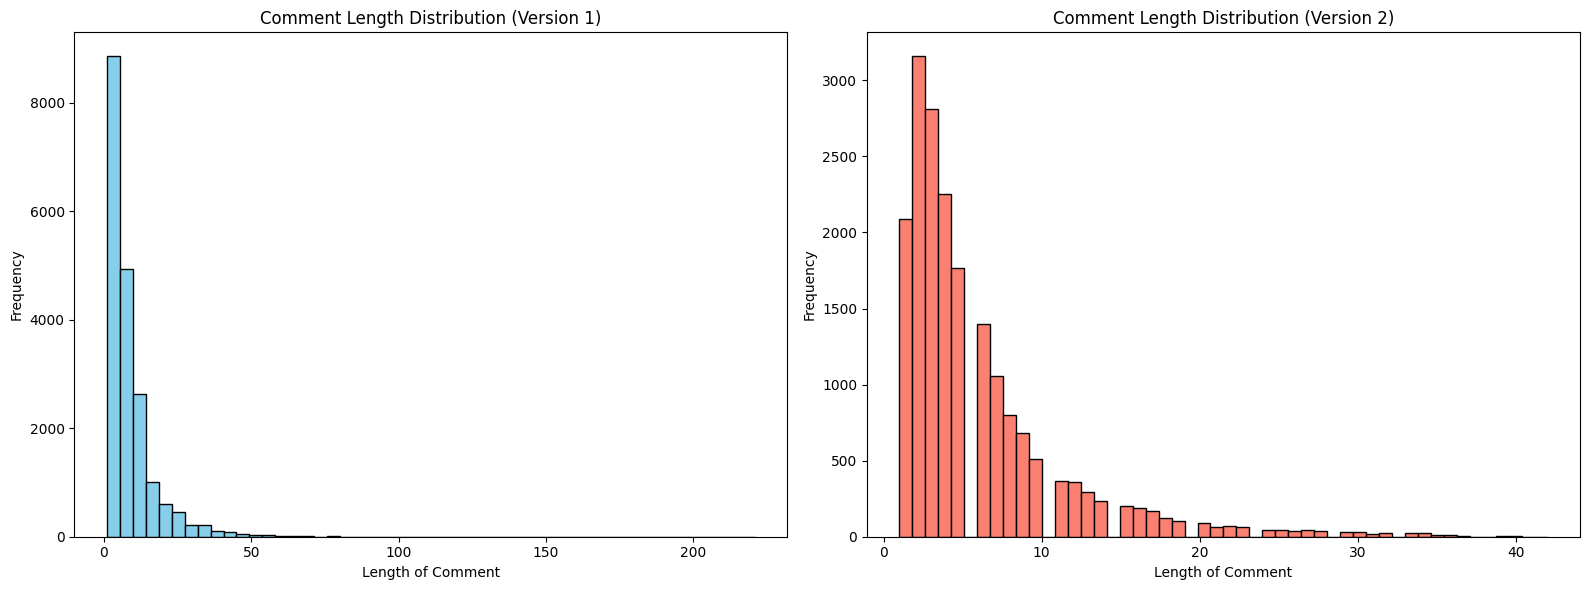

In [140]:
# plot length distribution after removing long comments
plot_length_distribution(df)

In [142]:
english_df = df[df['clean_comment_v2'].apply(is_english)]
positive = english_df[english_df['sentiment'] == 'positive']
positive = " ".join(positive['clean_comment_v2'].to_list()[:400])

negative = english_df[english_df['sentiment'] == 'negative']
negative = " ".join(negative['clean_comment_v2'].to_list()[:400])

neutral = english_df[english_df['sentiment'] == 'neutral']
neutral = " ".join(neutral['clean_comment_v2'].to_list()[:400])

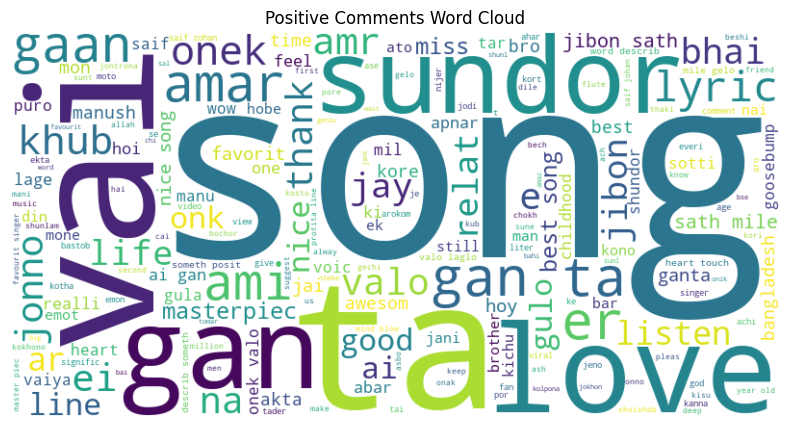

In [143]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(positive)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Comments Word Cloud")
plt.savefig('./figures/positive_wordcloud.png')
plt.show()

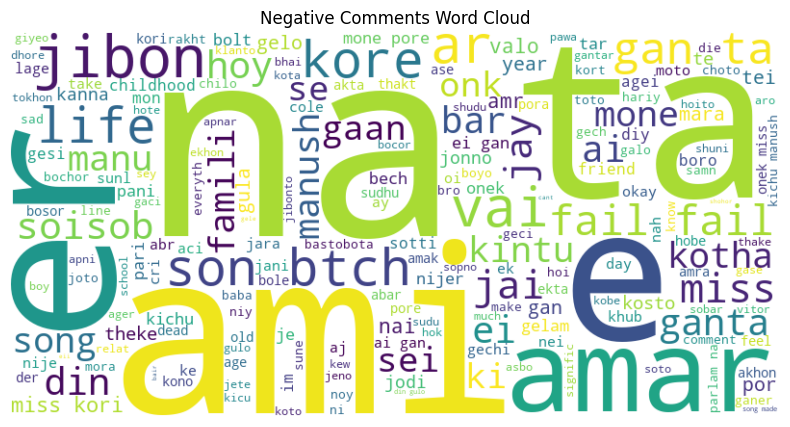

In [144]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(negative)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Comments Word Cloud")
plt.savefig('./figures/negative_wordcloud.png')
plt.show()

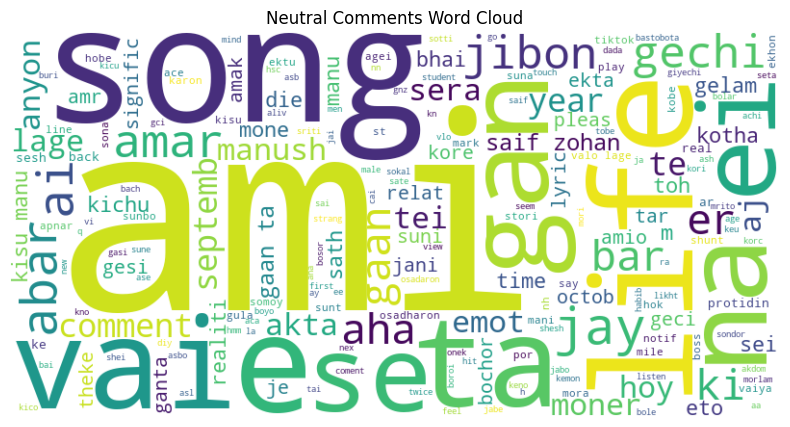

In [145]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(neutral)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Neutral Comments Word Cloud")
plt.savefig('./figures/neutral_wordcloud.png')
plt.show()

In [146]:
del positive, negative, neutral, english_df, wc

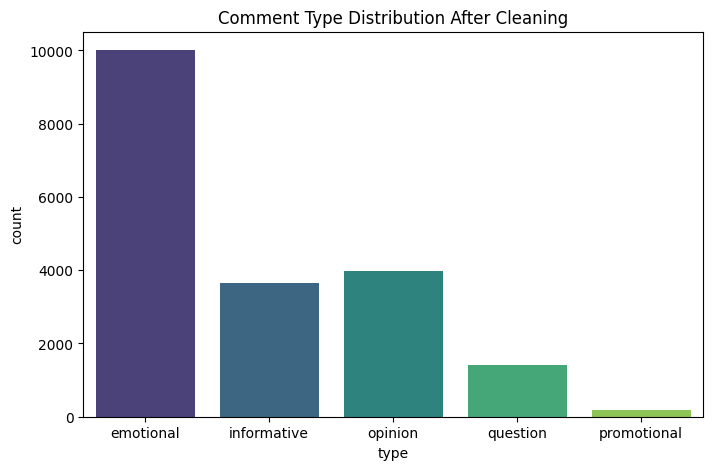

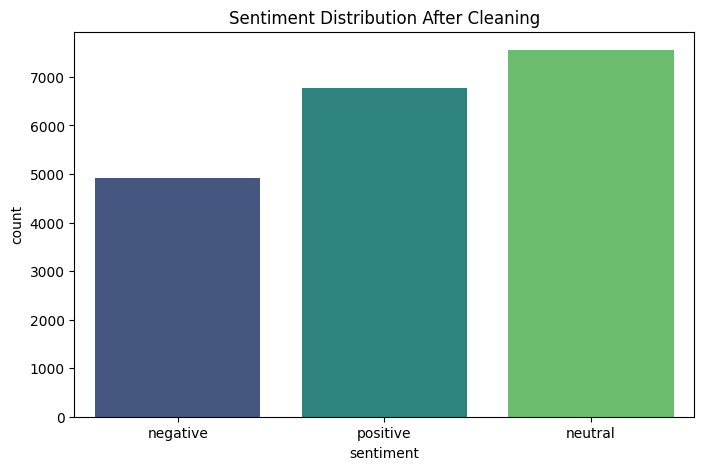

In [147]:
# comment type distribution after cleaning
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='viridis')
plt.title("Comment Type Distribution After Cleaning")
plt.savefig('./figures/comment_type_distribution_after_cleaning.png')
plt.show()

# sentiment distribution after cleaning
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title("Sentiment Distribution After Cleaning")
plt.savefig('./figures/sentiment_distribution_after_cleaning.png')
plt.show()

In [148]:
df.head()

,type,sentiment,clean_comment_v1,clean_comment_v2,seq_len_v1,seq_len_v2
0,emotional,negative,গানটা যখন শুনছি তখনই এই শহরটা ছাড়ার ঘন্টা বেঁজ...,গান শুন তখন শহর ছাড়া ঘন্ বেঁজে মাসে বাসা ছেড়েছ...,48,28
1,emotional,positive,tnx gan ta onak sundorwe hope that amon sundor...,tnx gan ta onak sundorw hope amon sundor gan a...,12,11
2,emotional,negative,ei shohor amar are or our noy,ei shohor amar noy,7,4
3,emotional,positive,যারা নিজের এলাকা ছেড়ে দূরে চলে গেছে তাদের জন্য...,এলাকা ছাড় গান সুর নয়প্রতি লাইনই একেক স্মৃতির আকাশ,18,9
4,informative,positive,আজ ২২১০২৫ স্মীতি রেখে গেলাম আপনাদের মাঝেযখনই ল...,স্মীতি গেল আপনা মাঝেযখন লাইক দিব নোটিফিকেশন আস...,14,9


In [149]:
df.drop(columns=['seq_len_v1', 'seq_len_v2'], inplace=True)
df.rename(columns={'clean_comment_v1': 'comment_v1', 'clean_comment_v2': 'comment_v2'}, inplace=True)
df= shuffle(df).reset_index(drop=True)
df.head()

,type,sentiment,comment_v1,comment_v2
0,emotional,negative,এই শহর আর আমার নয়,শহর
1,informative,neutral,e kamon cenema ar video koro dada,e kamon cenema ar video koro dada
2,emotional,neutral,ha obossoi arokom video chai,ha obossoi arokom video chai
3,emotional,neutral,ক39দিন ধরে মন টা ভালো নেই কষ্টের কারন হচ্ছে কে...,কদিন মন ভালো কষ্ট কারন মন ভালো সেইটাই বুজ পারছ...
4,emotional,neutral,life is a drink and love is a drug,life drink love drug


In [151]:
# Reorder the columns
df = df[['comment_v1', 'comment_v2', 'type', 'sentiment']]
df.head()

,comment_v1,comment_v2,type,sentiment
0,এই শহর আর আমার নয়,শহর,emotional,negative
1,e kamon cenema ar video koro dada,e kamon cenema ar video koro dada,informative,neutral
2,ha obossoi arokom video chai,ha obossoi arokom video chai,emotional,neutral
3,ক39দিন ধরে মন টা ভালো নেই কষ্টের কারন হচ্ছে কে...,কদিন মন ভালো কষ্ট কারন মন ভালো সেইটাই বুজ পারছ...,emotional,neutral
4,life is a drink and love is a drug,life drink love drug,emotional,neutral


In [152]:
# save the cleaned dataset
df.to_csv("./data/clean_youtube_comment_dataset.csv", index=False)

In [153]:
# encode the target columns with label encoder
type_le = LabelEncoder()
sentiment_le = LabelEncoder()

df['type'] = type_le.fit_transform(df['type'])
df['sentiment'] = sentiment_le.fit_transform(df['sentiment'])

In [154]:
df.head()

,comment_v1,comment_v2,type,sentiment
0,এই শহর আর আমার নয়,শহর,0,0
1,e kamon cenema ar video koro dada,e kamon cenema ar video koro dada,1,1
2,ha obossoi arokom video chai,ha obossoi arokom video chai,0,1
3,ক39দিন ধরে মন টা ভালো নেই কষ্টের কারন হচ্ছে কে...,কদিন মন ভালো কষ্ট কারন মন ভালো সেইটাই বুজ পারছ...,0,1
4,life is a drink and love is a drug,life drink love drug,0,1


In [158]:
# save the label encoders
joblib.dump(type_le, './models/type_encoder.pkl')
joblib.dump(sentiment_le, './models/sentiment_encoder.pkl')

['./models/sentiment_encoder.pkl']

In [159]:
# split the dataset into train, validation, and test sets
train, temp = train_test_split(df, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

train.shape, valid.shape, test.shape

((15393, 4), (1924, 4), (1925, 4))

In [160]:
# saving the datasets
train.to_csv("./data/train_dataset.csv", index=False)
valid.to_csv("./data/valid_dataset.csv", index=False)
test.to_csv("./data/test_dataset.csv", index=False)